In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
print("tf version:",tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras import regularizers # type: ignore
import os 
import sys
# from functions import data_ingstion, correlation_matrix, train_test_split, normalizer_function, compile_and_fit, training_score, evaluate, predict_func, tensor_convertor
# from functions import data_ingstion, train_test_split, normalizer_function, compile_and_fit, training_score, evaluate, predict_func, tensor_convertor

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

tf version: 2.9.0


In [2]:
print(f"model trained :RandomForestRegressor")


model trained :RandomForestRegressor


In [2]:
BATCH_SIZE = 32
EPOCHS=10
n_features = 16  # Number of features
n_timesteps = 1


In [3]:
def data_ingstion():
    # try:
        dfs = pd.read_parquet(r"D:\RND\Machine_Learning\Datasets/clean_dataset_ml_50_id.parquet")
        dfs.fillna(0,inplace=True)
        df = dfs.copy()
        df['creation_time'] = pd.to_datetime(df['creation_time'])
        df.set_index(['creation_time'],drop= True, inplace= True)
        # df["min"] = df.index.minute
        df.sort_index(inplace=True)
        df.reset_index(drop=True,inplace=True)
        dataframe_tensor = tf.convert_to_tensor(df, dtype=tf.float32)
        reshaped_tensor = tf.reshape(dataframe_tensor, (dataframe_tensor.shape[0], n_timesteps, dataframe_tensor.shape[1]))
        
        # logger.info(f"columns in df : {tuple(df.columns)}")
        # logger.info(f"shape of dataframe : {tuple(df.shape)}")
        return reshaped_tensor
    # except Exception as e:
    #     logger.error(f"error in data ingestion:{e}",exc_info=True)
df = data_ingstion()
print("len df: ",len(df))

len df:  225623


In [4]:

def data_ingstion():
    # try:
        dfs = pd.read_parquet(r"D:\RND\Machine_Learning\Datasets/clean_dataset_ml_50_id.parquet")
        dfs.fillna(0,inplace=True)
        df = dfs.copy()
        df['creation_time'] = pd.to_datetime(df['creation_time'])
        df.set_index(['creation_time'],drop= True, inplace= True)
        # df["min"] = df.index.minute
        df.sort_index(inplace=True)
        df.reset_index(drop=True,inplace=True)
        # logger.info(f"columns in df : {tuple(df.columns)}")
        # logger.info(f"shape of dataframe : {tuple(df.shape)}")
        return df
    # except Exception as e:
    #     logger.error(f"error in data ingestion:{e}",exc_info=True)
df = data_ingstion()

def tensor_conversion(dataframe):
    # try:
        dataframe_tensor = tf.convert_to_tensor(dataframe, dtype=tf.float32)
        return dataframe_tensor
    # except Exception as e:
    #     logger.error(f"error in tensor_conversion: {e}",exc_info=True)
def train_test_split(df):
    # try:
        # column_indices = {name: i for i, name in enumerate(df.columns)}
        n = len(df)
        train_df = df[0:int(n*0.9)]
        # val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]
        train_features, test_features = train_df.copy(),test_df.copy() #,val_df.copy()
        train_labels = train_features.pop('consumed_unit')
        # val_labels = val_features.pop('consumed_unit')
        test_labels = test_features.pop('consumed_unit')
        train_features_array = train_features.to_numpy()
        test_features_array = test_features.to_numpy()
        train_features = train_features_array.reshape((train_features.shape[0], n_timesteps, n_features))
        test_features = test_features_array.reshape((test_features.shape[0], n_timesteps, n_features))
        train_features = tensor_conversion(train_features)
        test_features = tensor_conversion(test_features)
        train_labels = tensor_conversion(train_labels)
        test_labels = tensor_conversion(test_labels)
        print(f"train_features shape:{train_features.shape},train_label shape: {train_labels.shape}")
        # print(f"val_features shape:{val_features.shape},val_label shape: {val_labels.shape},val_labels type: {type(val_labels)}")
        print(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
        # logger.info(f"data split done")
        # logger.info(f"train_features shape:{train_features.shape},train_label shape: {train_labels.shape}")
        # logger.info(f"val_features shape:{val_features.shape},val_label shape: {val_labels.shape},val_labels type: {type(val_labels)}")
        # logger.info(f"test_features shape:{test_features.shape} ,test_label shape: {test_labels.shape}")
        return train_features,test_features,train_labels, test_labels
    # except Exception as e:
    #     logger.error(f"error in split: {e}",exc_info=True)
train_features,test_features,train_labels,test_labels = train_test_split(df)
def normalizer_function(df):
    # try:
        # df_mean, df_std = df.mean(), df.std()
        # df = (df - df_mean) / df_std
        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(df))
        return normalizer
    
    # except Exception as e:
    #     logger.error(f"error in normalizer: {e}",exc_info=True)

normalizer = normalizer_function(train_features)

train_features shape:(203060, 1, 16),train_label shape: (203060,)
test_features shape:(22563, 1, 16) ,test_label shape: (22563,)


In [41]:

model = Sequential([
    normalizer,
    layers.LSTM(64, activation='relu', input_shape=(n_timesteps,n_features), return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),  # Dropout to reduce overfitting
    layers.LSTM(32, activation='relu', return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

In [42]:

def compile_and_fit(model,
                    train_features = None,
                    train_labels = None, 
                    patience=5,
                    batch_size = None,
                    MAX_EPOCHS = None,
                    learning_rate = None,                    
                    ):
    try:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=patience,
                                                            mode='min')

        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

        history = model.fit(train_features,train_labels, epochs=MAX_EPOCHS,
                            validation_split=0.2,
                            callbacks=[early_stopping],
                            verbose=1,
                            )
        return model, history
    except Exception as e:
        print(f"error in compiling and fitting: {e},exc_info=True")


In [ ]:
history,model = compile_and_fit(model, train_features, train_labels, batch_size= BATCH_SIZE,MAX_EPOCHS = EPOCHS, learning_rate= 0.0001)


In [48]:
history, model = model, history

In [50]:
history.history

{'loss': [5.994061470031738,
  3.3696393966674805,
  3.2344892024993896,
  3.146559715270996,
  3.105752944946289,
  3.0853662490844727,
  3.0372426509857178,
  3.027982711791992,
  3.0132648944854736,
  2.983635187149048],
 'mean_absolute_error': [1.142689824104309,
  0.7851887345314026,
  0.7574859261512756,
  0.7408820986747742,
  0.7325731515884399,
  0.7250856757164001,
  0.7190268039703369,
  0.7156286239624023,
  0.7108430862426758,
  0.709140419960022],
 'val_loss': [2.7493815422058105,
  2.4497549533843994,
  2.349773645401001,
  2.3019001483917236,
  2.2889792919158936,
  2.2642595767974854,
  2.2585880756378174,
  2.252678155899048,
  2.2468175888061523,
  2.236602544784546],
 'val_mean_absolute_error': [0.7910307049751282,
  0.6719769835472107,
  0.6264499425888062,
  0.6032987833023071,
  0.6110283136367798,
  0.6024049520492554,
  0.5967060923576355,
  0.5962456464767456,
  0.6013361215591431,
  0.5959300994873047]}

In [9]:
train_features_array = train_features.to_numpy()
test_features_array = test_features.to_numpy()
n_timesteps = 1  # Each sample has 1 timestep (since features are already lagged)
n_features = 16  # Number of features

X_train = train_features_array.reshape((train_features.shape[0], n_timesteps, n_features))
X_test = test_features_array.reshape((test_features.shape[0], n_timesteps, n_features))

In [ ]:
train_features.to_numpy()[0].shape[0]

In [ ]:
X_train.shape

In [54]:
"""simple_version"""
# model = keras.Sequential([
#       normalizer,
#       layers.Dense(64, activation='relu',input_shape=(16,)),
#       layers.Dense(32, activation='relu'),
#       layers.Dense(16, activation='relu'),
#       layers.Dense(1)])

""" sequential better version"""
input_shape = (16,)
# model = keras.Sequential([
#     normalizer,
#     layers.Dense(64, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(1)
# ])
"""lstm basic version"""
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Normalization(axis=-1, input_shape=input_shape),
#     tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(64, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

"""lstm better version"""
# Reshape data for LSTM
train_features_array = train_features.to_numpy()
test_features_array = test_features.to_numpy()
n_timesteps = 1  # Each sample has 1 timestep (since features are already lagged)
n_features = 16  # Number of features

X_train = train_features_array.reshape((train_features.shape[0], n_timesteps, n_features))
X_test = test_features_array.reshape((test_features.shape[0], n_timesteps, n_features))

# Define LSTM model
model = Sequential([
    layers.LSTM(64, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),  # Dropout to reduce overfitting
    layers.LSTM(32, activation='relu', return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])



In [55]:
# Create a callback that saves the model's weights
# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
def compile_and_fit(model,
                    train_features = train_features,
                    train_labels = train_labels, 
                    patience=5,
                    batch_size = None,
                    MAX_EPOCHS = 100):
        
    # checkpoint_path = "training_1/cp.ckpt"
    # checkpoint_dir = os.path.dirname(checkpoint_path)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min',
                                                        restore_best_weights=True)
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
    #                                              save_weights_only=True,
    #                                              verbose=1)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(0.0001),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(train_features,train_labels, epochs=MAX_EPOCHS,
                        validation_split=0.2,
                        # callbacks=[
                            # early_stopping,
                            # cp_callback],  # Combine callbacks in a single list
                        verbose=1,
                        )
           
    return history, model


In [ ]:
history,model = compile_and_fit(model,X_train,train_labels,batch_size= 16)

In [ ]:
def compile_and_fit(model,
                    train_features,
                    train_labels, 
                    patience=5,
                    batch_size=None,
                    MAX_EPOCHS=100):
        
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min',
        restore_best_weights=True
    )
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(0.0001),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    history = model.fit(
        train_features,
        train_labels,
        epochs=MAX_EPOCHS,
        validation_split=0.2,
        callbacks=[early_stopping, cp_callback],
        verbose=1,
        batch_size=batch_size  # Ensure batch_size is passed if needed
    )
           
    return history, model

history, model = compile_and_fit(model, train_features=X_train, train_labels=train_labels, batch_size=16)


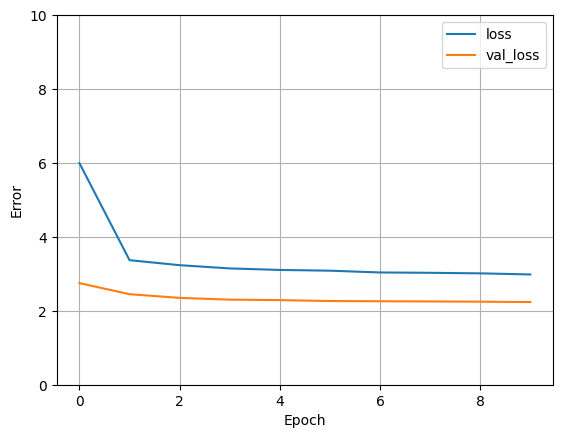

In [51]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
  
plot_loss(history)

In [52]:

# Evaluate the model
loss, acc = model.evaluate(test_features, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

706/706 - 1s - loss: 2.9528 - mean_absolute_error: 0.6414 - 585ms/epoch - 829us/step
Untrained model, accuracy: 64.14%


In [54]:
def training_score(history):
    print(f"training_score:loss:{history.history['loss'][-1]:.3f},mae:{history.history['mean_absolute_error'][-1]:.3f}")

In [55]:
def evaluate(model,test_features= test_features,test_labels= test_labels):
    score = model.evaluate(val_features,val_labels,verbose=0)
    print("val_score:",score)
    return score
training_score(history)
# score = evaluate(model)    

training_score:loss:2.984,mae:0.709


In [58]:
def prediction(model, input_data,input_labels=None,verbose=1):
    y_pred = model.predict(input_data,verbose)
    print(type(y_pred))
    mae = mean_absolute_error(input_labels, y_pred)
    mse = mean_squared_error(input_labels, y_pred)
    # r2 = r2_score(input_labels, y_pred)

    print(f"mae: {mae:.3f}")
    print(f"mse: {mse:.3f}")
    # print(f"R2: {r2:.3f}")
    return y_pred
predicted_value = prediction(model,input_data=test_features,input_labels=test_labels)

22563/22563 [==============================] - 16s 693us/step
<class 'numpy.ndarray'>
mae: 0.641
mse: 2.856


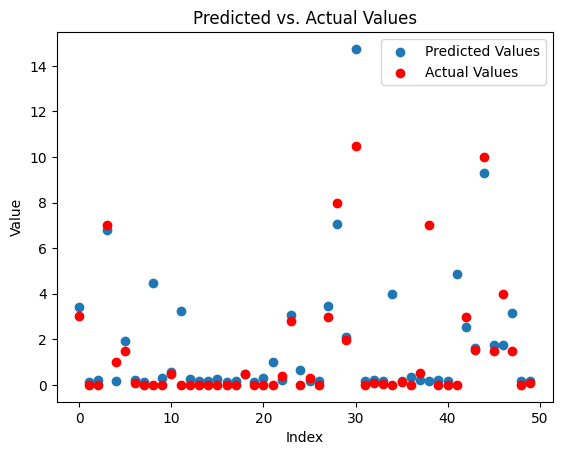

In [59]:
x = np.arange(len(predicted_value))
# start = 40
values = 50
x = np.arange(values)
plt.scatter(x, predicted_value[:values], label='Predicted Values')
plt.scatter(x, test_labels[:values], label='Actual Values', color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()


In [ ]:
first_dense_layer = model.layers[1]  
weights, biases = first_dense_layer.get_weights()
print("Weights shape:", weights.shape)
feature_importance = np.abs(weights).mean(axis=1)
for i, importance in enumerate(feature_importance):
    print(f"Feature {train_features.columns[i]}: Importance {importance}")

In [ ]:
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)
result = permutation_importance(model, test_features, test_labels, 
                                n_repeats=10, random_state=42, 
                                scoring=custom_scorer,
                                verbose=1)
sorted_idx = result.importances_mean.argsort()
for i in sorted_idx[::-1]:
    print(f"Feature {train_features.columns[i]}: Importance {result.importances_mean[i]:.8f}")

In [42]:

# Save the entire model as a `.keras` zip archive.
model.save('load_forecasting_lstm_model.keras')

In [ ]:
new_model = tf.keras.models.load_model('load_forecasting_model.keras')

# Show the model architecture
new_model.summary()

In [44]:

model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu',input_shape=(17,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)])

model.compile(loss='mean_absolute_error',
      # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
      optimizer=tf.keras.optimizers.Adam(0.001),
      metrics=['mean_squared_error',])


## with SGD

In [ ]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)

### with adam

In [ ]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
model.summary()